In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torch.optim as optim
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
print(torch.__version__)

2.7.1+cu128


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # or 32x32 if you want faster training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(root='kaggle_datasets/data/train', transform=transform)
test_dataset = ImageFolder(root='kaggle_datasets/data/test', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
for X, y in train_loader:
    print(X.shape,y.shape)
    break

torch.Size([64, 3, 64, 64]) torch.Size([64])


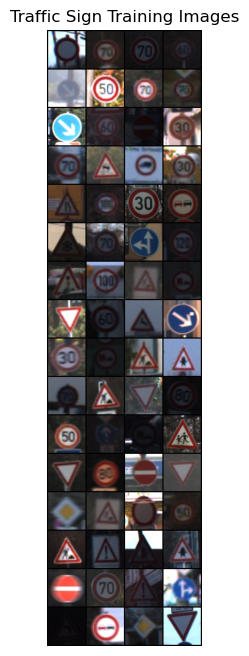

In [ ]:
images, labels = next(iter(train_loader))

# Undo normalization for visualization
images = images * 0.5 + 0.5  # unnormalize to [0, 1]

# Create a grid of 16 images (4x4)
img_grid = torchvision.utils.make_grid(images, nrow=4)

# Plot
plt.figure(figsize=(16, 8))
plt.imshow(img_grid.permute(1, 2, 0))  # [C, H, W] → [H, W, C]
plt.title("Traffic Sign Training Images")
plt.axis("off")
plt.show()

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()

        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1) #[16,64,64]
        self.pool = nn.MaxPool2d(2,2) # [16,32,32]
        self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1) #[32,32,32]
        self.pool = nn.MaxPool2d(2,2) # [32,16,16]
        self.conv3 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1) #[64,16,16]
        self.pool = nn.MaxPool2d(2,2) # [64,8,8]
        self.fc1 = nn.Linear(64*8*8,128)
        self.fc2 = nn.Linear(128,43)



    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=43, bias=True)
)

In [ ]:
#set loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # ✅ Send to GPU

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 1.2823
Epoch 2, Loss: 0.1642
Epoch 3, Loss: 0.0750
Epoch 4, Loss: 0.0480
Epoch 5, Loss: 0.0302


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 90.63%


In [ ]:
import random

def show_predictions(model, dataset, device, n=9):
    model.eval()
    indices = random.sample(range(len(dataset)), n)
    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(indices):
        x, y = dataset[idx]
        x_input = x.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x_input)
            predicted_label = pred.argmax(1).item()

        img = x * 0.5 + 0.5
        img = img.permute(1, 2, 0).cpu().numpy()

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f'Pred: {predicted_label}, Actual: {y}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


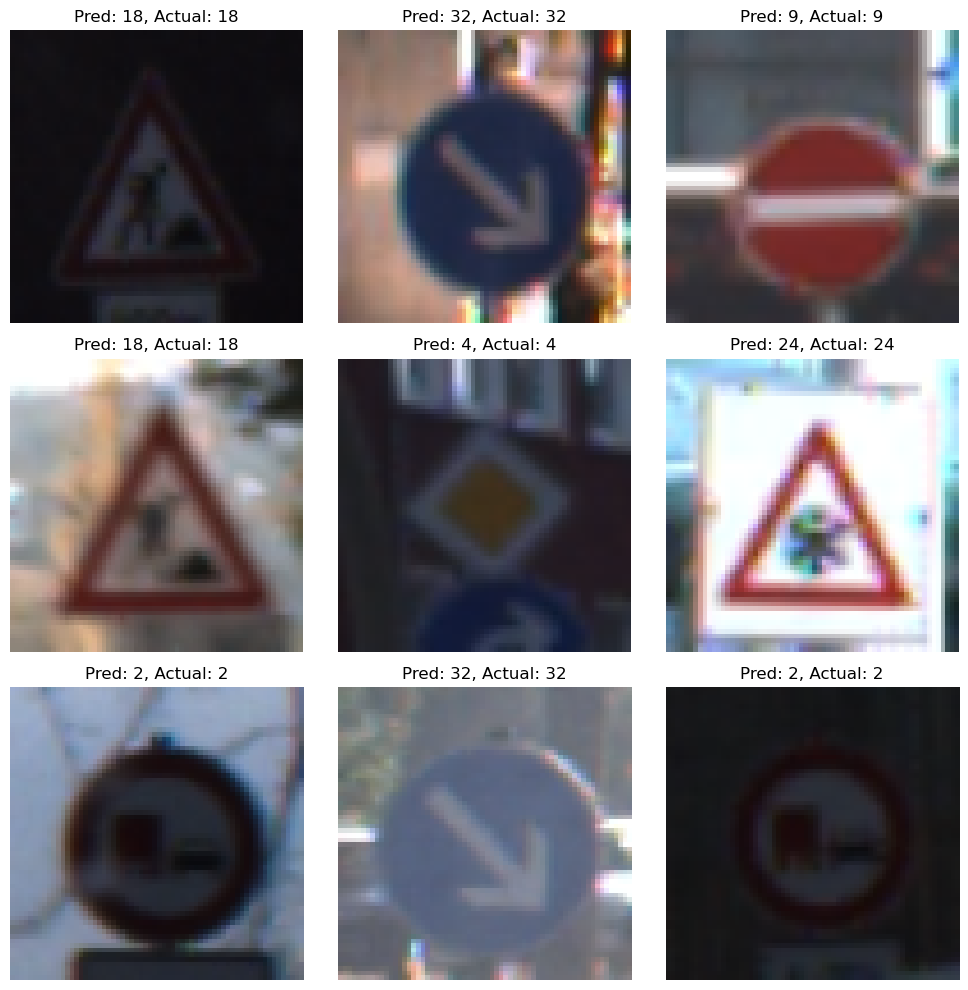

In [ ]:
show_predictions(model, train_dataset, device)

In [ ]:
torch.save(model.state_dict(), "../artifacts/model.pth")

RuntimeError: Parent directory artifacts does not exist.